In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from collections import OrderedDict
from torchvision.datasets import VisionDataset
from glob import glob
import os
import os.path
import pathlib
from typing import Any, Callable, Optional, Sequence, Tuple, Union
from PIL import Image
from torchvision.datasets.utils import download_and_extract_archive
from torchvision import datapoints
from torchvision.transforms import v2
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

/home/giangi/Workspace/Applications/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/giangi/Workspace/Applications/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change 

In [3]:
class OxfordIIITPetDataset(VisionDataset):
    """`Oxford-IIIT Pet Dataset   <https://www.robots.ox.ac.uk/~vgg/data/pets/>`_.
    Modified version from 
    https://pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html?highlight=oxford#torchvision.datasets.OxfordIIITPet
    Args:
        root (string): Root directory of the dataset.
        file_list (list): List of the jpg files to be used in the dataset as input. 
        transforms (callable, optional): A function/transforms that takes in an image and a label and returns the transformed versions of both.
        download (bool, optional): If True, downloads the dataset from the internet and puts it into
            ``root/oxford-iiit-pet``. If dataset is already downloaded, it is not downloaded again.
    """

    _RESOURCES = (
        ("https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", "5c4f3ee8e5d25df40f4fd59a7f44e54c"),
        ("https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", "95a8c909bbe2e81eed6a22bccdf3f68f"),
    )

    def __init__(
        self,
        root: str,
        file_list: Sequence[str],
        transforms: Optional[Callable] = None,
        download: bool = False,
    ):
        
        super().__init__(root, transforms=transforms)
        self._base_folder = pathlib.Path(self.root) 
        self._images_folder = self._base_folder / "images"
        self._anns_folder = self._base_folder / "annotations"
        self._segs_folder = self._anns_folder / "trimaps"

        if download:
            self._download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found. You can use download=True to download it")

        
        self._images = [self._images_folder / f"{image}" for image in file_list]
        self._segs = [self._segs_folder/ f"{image.replace('.jpg','.png')}" for image in file_list]

    def __len__(self) -> int:
        return len(self._images)

    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        image = Image.open(self._images[idx]).convert("RGB")
        target = Image.open(self._segs[idx])

        if self.transforms:
            image = datapoints.Image(image)
            target = datapoints.Mask(target)
            image, target = self.transforms(image, target)

        return image, (target - 1).long()

    def _check_exists(self) -> bool:
        for folder in (self._images_folder, self._anns_folder):
            if not (os.path.exists(folder) and os.path.isdir(folder)):
                return False
        else:
            return True

    def _download(self) -> None:
        if self._check_exists():
            return

        for url, md5 in self._RESOURCES:
            download_and_extract_archive(url, download_root=str(self._base_folder), md5=md5)
def get_datasets(root:str,
                 splits: Union[Sequence[float],float],
                 transforms: Optional[Callable]=None,
                 download: bool=False) -> Tuple[type(OxfordIIITPetDataset)]:
    """
    Create datasets based on splits.
    inputs:
        root: (str) root dir of dataset. Something like 'your_path/oxford-iiit-pet'
        splits: (list[float] | float). If float indicates the split for training set and the split for validation set is (1 - splits).
                If list the first two are the train and validation split and the test split is 1 - sum(splits).
        transforms: (torch list) Sequence of torchvision transfomations to apply to the datasets.
        download: (bool) Download the dataset if not found in root.
    """
    if not isinstance(splits,list):
        splits = [splits]
    assert len(splits) < 3, f'Provide a max of two splits. Third is inferred if needed.'
    splits = np.array(splits)
    assert splits.sum() < 1, f'The total split cannot be greater than 1'
    splits = np.append(splits,(1 - splits.sum()))
    #create list of all files available
    ls = glob(os.path.join(root,'images','*.jpg'))
    ls = np.array([os.path.basename(l) for l in ls])
    indx = np.arange(len(ls))
    #shuffle done in place
    np.random.shuffle(indx)
    #shuffle the list of files
    ls = ls[indx]
    #create the indices for each split
    file_splits = [0]
    file_splits.extend(np.cumsum(splits)*len(ls))
    file_splits = np.array(file_splits).astype(int)
    #get datesets
    datasets = []
    for i in range(1,len(file_splits)):
        file_list = ls[file_splits[i-1]:file_splits[i]]
        datasets.append(OxfordIIITPetDataset(root,file_list,transforms,download))
    return datasets


In [4]:
class Unet(nn.Module):
    def __init__(self,nclass,kernel_size=3,in_ch=3,start_ch=64,end_ch=1024):
        """
        Unet model for image segmentation.
        inputs:
            nclass: (int) number of classes in the segmentation.
            kernel_size: (int) kernel size for 2D convolutions.
            in_ch: (int) number of input channels in the image.
            start_ch: (int) starting number of features maps (must be a power of 2).
            end_ch: (int) ending number of features maps (must be a power of 2 and larger than start_ch).
        """
        super().__init__()
        self.nclass = nclass
        self.kernel_size = kernel_size
        self.in_ch = in_ch
        self.start_ch = start_ch
        self.end_ch = end_ch
        assert np.log2(end_ch)%int(np.log2(end_ch)) == 0,f'end_ch must be a power of 2 but got {end_ch}'
        assert np.log2(start_ch)%int(np.log2(start_ch)) == 0,f'start_ch must be a power of 2 but got {start_ch}'
        #compute number of layers
        self.nlayers = int(np.log2(end_ch) - np.log2(start_ch))
        self.out_layer = nn.Conv2d(self.start_ch,self.nclass,kernel_size=1)
        self.down_layers = OrderedDict()
        self.down_layers['c0'] = self.down_step('conv',self.in_ch,self.start_ch,self.kernel_size)
        self.down_layers['m0'] = self.down_step('max')
        #### NOTE: need to setattr otherwise model does not know the model structure and what to put on the GPU
        setattr(self,'down_layers_c0',self.down_layers['c0'])
        setattr(self,'down_layers_m0',self.down_layers['m0'])
        #create down sampling portion of Unet
        start = self.start_ch
        for i in range(1,self.nlayers + 1):
            self.down_layers[f'c{i}'] = self.down_step('conv',start,start*2,self.kernel_size)
            setattr(self,f'down_layers_c{i}',self.down_layers[f'c{i}'])
            self.down_layers[f'm{i}'] = self.down_step('max')
            setattr(self,f'down_layers_m{i}',self.down_layers[f'm{i}'])
            start *= 2
        #create up sampling portion of Unet
        self.up_layers = OrderedDict()
        for i in range(self.nlayers):
            self.up_layers[f't{i}'] = self.up_step('transp',start,start//2,self.kernel_size)
            setattr(self,f'up_layers_t{i}',self.up_layers[f't{i}'])
            self.up_layers[f'c{i}'] = self.up_step('conv',start,start//2,self.kernel_size)
            setattr(self,f'up_layers_c{i}',self.up_layers[f'c{i}'])
            start //= 2
    
    #Encapsulate the down steps
    def down_step(self,which,in_ch=None,out_ch=None,kernel_size=3):
        if which == 'conv':
            model = nn.Sequential(
                nn.Conv2d(in_ch,out_ch,kernel_size=kernel_size,padding=kernel_size//2),
                nn.ReLU(),
                nn.Conv2d(out_ch,out_ch,kernel_size=kernel_size,padding=kernel_size//2),
                nn.ReLU()
            )
        elif which == 'max':
            model = nn.MaxPool2d(kernel_size=2,stride=2)
        return model
    #Encapsulate the up steps
    def up_step(self,which,in_ch,out_ch,kernel_size=3):
        if which == 'transp':
            model = nn.ConvTranspose2d(in_ch,out_ch,kernel_size=2,stride=2)        
        elif which == 'conv':
            model = nn.Sequential(
                nn.Conv2d(in_ch,out_ch,kernel_size=kernel_size,padding=kernel_size//2),
                nn.ReLU(),
                nn.Conv2d(out_ch,out_ch,kernel_size=kernel_size,padding=kernel_size//2),
                nn.ReLU()
            )
        else:
            raise ValueError(f'Unrecognized option  {which} in up_step')
        return model
    
    def forward(self,x):
        skip_conns = []
        for i in range(0,self.nlayers + 1):
            x1 = self.down_layers[f'c{i}'](x)
            skip_conns.append(x1)
            if i < self.nlayers:
                x = self.down_layers[f'm{i}'](x1)
            else:
                #no max pool on last layer
                x = x1
        #skip connections escluding last one and in reverse order
        skip_conns = skip_conns[:-1][::-1]
        for i in range(0,self.nlayers):
            x = self.up_layers[f't{i}'](x)
            x = torch.cat([x,skip_conns[i]],dim=1)
            x = self.up_layers[f'c{i}'](x)
        return self.out_layer(x)

def train_one_epoch(epoch_index,model,loss_fn,training_loader,optimizer, tb_writer,print_every=100,device='cuda'):
    """
    Modified version from Pytorch web site. Passed arguments explicitly. 
    """
    running_loss = 0.
    last_loss = 0.
    #print info only print_every is > 0.
    do_print = True if print_every > 0 else False
    print_every = abs(print_every)

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.to(device))

        # Compute the loss and its gradients
        loss = loss_fn(outputs, torch.squeeze(labels,dim=1).to(device))
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % print_every == print_every - 1:
            last_loss = running_loss / print_every # loss per batch
            if do_print:
                print(f'batch {i+1} loss: {last_loss}')
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

def do_eval(model,loss_fn,validation_loader,device='cuda'):
    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs.to(device))
            vloss = loss_fn(voutputs, torch.squeeze(vlabels,dim=1).to(device))
            running_vloss += vloss
    return running_vloss,i

In [5]:
resize_to = 256
crop_to = 128
transforms = v2.Compose(
[
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize(resize_to),#resize to a square image regardless of aspect ratio
    v2.RandomCrop(crop_to,pad_if_needed=True,padding_mode='reflect'),#get a smaller random crop
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.Normalize(mean=[122.77501094, 114.35478415, 100.70178351],std=[60.77974999, 60.06723026, 60.7853755 ]),
]
)
#If forget to restart kernel do some manual cleanup
torch.cuda.empty_cache()
device = 'cuda'
batch_size = 64
root = '/home/giangi/Workspace/Data/oxford-iiit-pet'
train_ds,val_ds = get_datasets(root,.8,transforms=transforms)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=batch_size,shuffle=True)
model = Unet(3).to(device)
lr = 0.1
base_lr = 0.001
max_lr = 0.1
step_size_up = 10
gamma_sch = .9
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,step_size_up=step_size_up,mode="exp_range",gamma=gamma_sch,cycle_momentum=False)
#can play with weight_loss to give more weight to most mislabeled
weight_loss = torch.ones(3).to(device)
loss_fn = nn.CrossEntropyLoss(weight_loss)
# lrs = []
# for i in range(100):
#     optimizer.step()
#     lrs.append(optimizer.param_groups[0]["lr"])
# #     print("Factor = ",i," , Learning Rate = ",optimizer.param_groups[0]["lr"])
#     scheduler.step()
# plt.figure()
# plt.plot(lrs)



In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/unet_trainer_{timestamp}')
epoch_number = 0
print_every = 10
EPOCHS = 100
model_dir = 'models'
best_vloss = 1e10

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch_number + 1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch,model,loss_fn,train_dl,optimizer,writer,print_every,device)
    scheduler.step()

    running_vloss,i = do_eval(model,loss_fn,val_dl,device)

    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {avg_loss} valid {avg_vloss}')

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                     {'Training:': avg_loss, 'Validation' : avg_vloss} ,
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = os.path.join(model_dir,f'unet_model_{timestamp}_{epoch_number}')
        torch.save(model.state_dict(), model_path)

    epoch_number += 1


In [ ]:
#Get all the pridictions and labels to check accuracy
device = 'cuda'
model = Unet(3).to(device)
model.load_state_dict(torch.load('models/model_20240212_105117_67'))
tot_lab = []
tot_pred = []
to_plt = []
model.eval()
# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    for i, vdata in enumerate(val_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs.to(device))
        vout = np.argmax(voutputs.detach().to('cpu').numpy().transpose([0,2,3,1]),axis=3)
        vlab = np.squeeze(vlabels.detach().to('cpu').numpy().transpose([0,2,3,1]))
        if i == len(val_dl) - 2:
            to_plt = [vinputs, vlab.copy(),vout.copy()]
        tot_lab.append(vlab) 
        tot_pred.append(vout)
        
tot_lab = np.concatenate(tot_lab)
tot_pred = np.concatenate(tot_pred)

In [14]:
#compute confusion matrix manually. normalize w.r.t. true values
cm = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        cm[i,j] += np.where((tot_lab == i)*(tot_pred == j))[0].size
cm/cm.sum(1)

array([[0.91054712, 0.07363962, 0.13030507],
       [0.06489728, 0.85676076, 0.14864369],
       [0.0743135 , 0.0529646 , 0.58270285]])

<IPython.core.display.Javascript object>


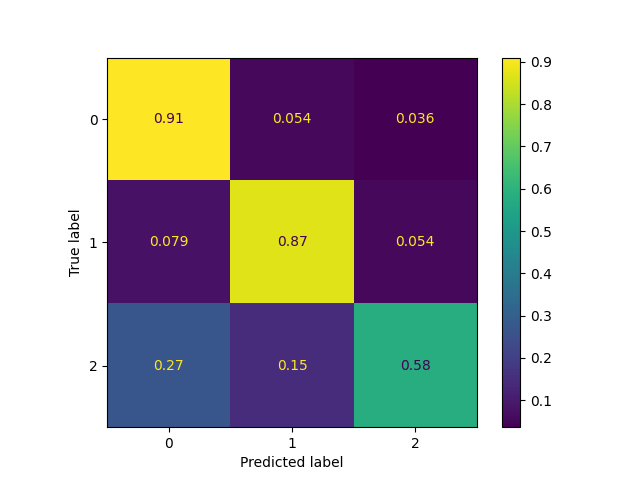

In [7]:
#plot confusion matrix. normalize w.r.t. true values
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(tot_lab.reshape([-1]),tot_pred.reshape([-1]),normalize='true')

Text(0.5, 1.0, '|Truth - Pred|')

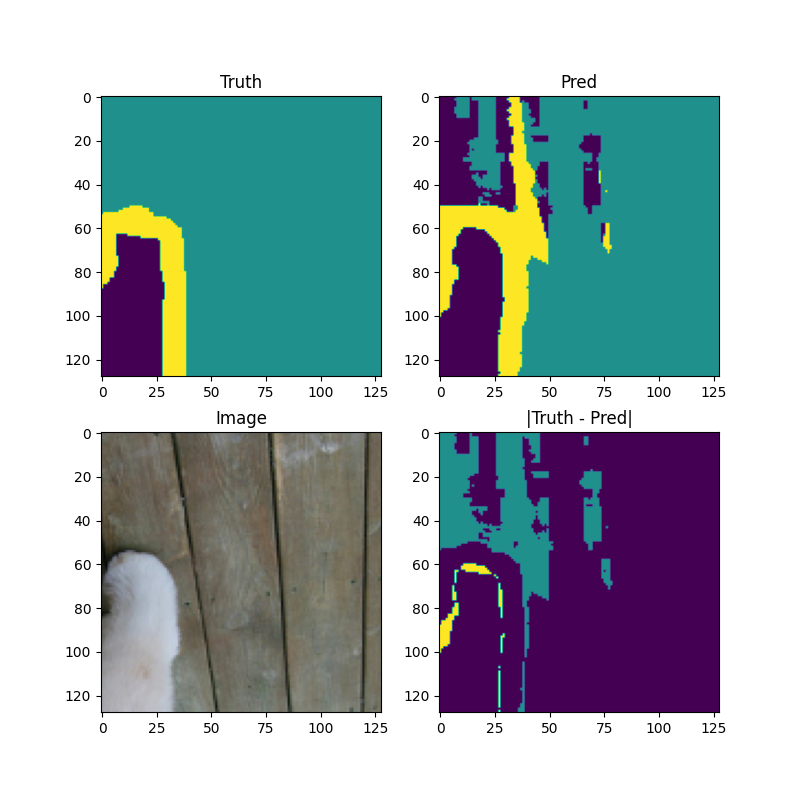

In [13]:
#use the second to last batch save above to do some plotting
vout = to_plt[2]
vlab = to_plt[1]
vin = to_plt[0].detach().to('cpu').numpy().transpose([0,2,3,1])
mean = np.array([122.77501094, 114.35478415, 100.70178351])
std = np.array([60.77974999, 60.06723026, 60.7853755 ])
#un-normalize the input images
vin = np.round(std*vin + mean).astype(int)

i = np.random.randint(0,len(vout))
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(vlab[i])
plt.title('Truth')
plt.subplot(2,2,2)
plt.imshow(vout[i])
plt.title('Pred')
plt.subplot(2,2,3)
plt.imshow(vin[i])
plt.title('Image')
plt.subplot(2,2,4)
plt.imshow(np.abs(vout[i] - vlab[i]))
plt.title('|Truth - Pred|')


In [114]:
#Compute mean and std to normalize
ls = glob('/home/giangi/Workspace/Data/oxford-iiit-pet/images/*.jpg')
sizes = []
means = []
for l in ls:
    image = np.array(Image.open(l).convert("RGB"))
    mean = [image.size//3]
    mean.extend(image.mean((0,1)))
    mean.extend(image.std((0,1))**2)
    means.append(mean)
sizes = np.array(sizes)

means = np.array(means)
ms = means[:,0][:,None]*means[:,1:]
norm = ms.sum(0)/means[:,0].sum()
norm_avg = norm[:3]
norm_std = norm[3:]**.5
norm_avg,norm_std

In [14]:
#check the distribution of the labels (foreground,backgrond and edges)
ls = glob('/home/giangi/Workspace/Data/oxford-iiit-pet/annotations/trimaps/*.png')
cnt = {1:0,2:0,3:0}
for l in ls:
    image = np.array(Image.open(l))
    for k in cnt.keys():
        cnt[k] += np.where(image == k)[0].size


In [17]:

tot = 0
for v in cnt.values():
    tot += v
for v in cnt.values():
    print(v/tot)

0.29521084020918303
0.589008075910973
0.11578108387984394
